Intention: To figure out how Zapier trends are vs the average, in attempt to find how demand may (or may not be) for these types of developer tools in relation to AI development

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np



In [2]:
# Read in public developer activity
data = pd.read_csv('ff.csv')


In [19]:
# Convert 'month' to datetime
data['month'] = pd.to_datetime(data['month'])

# Filter out September 2024 - incomplete month
data = data[data['month'] < '2024-09-01']

# Filter data for the complete years (2023 and 2024)
data = data[data['month'].dt.year.isin([2023, 2024])]

# Separate Zapier data
zapier_data = data[data['keyword_category'] == 'zapier'].set_index('month')

# Aggregate all other categories as 'AI-related APIs'
ai_apis_data = data[data['keyword_category'] != 'zapier'].groupby('month')['new_repo_count'].sum().reset_index()
ai_apis_data = ai_apis_data.set_index('month')



In [20]:
# Calculate 7-day rolling average for smoothing
zapier_data['rolling_avg'] = zapier_data['new_repo_count'].rolling(window=7).mean()
ai_apis_data['rolling_avg'] = ai_apis_data['new_repo_count'].rolling(window=7).mean()



In [21]:
# Calculate 95% confidence intervals
def calculate_ci(data):
    confidence = 0.95
    degrees_of_freedom = len(data) - 1
    sample_mean = np.mean(data)
    sample_standard_error = stats.sem(data)

    ci = stats.t.interval(confidence=confidence,
                          df=degrees_of_freedom,
                          loc=sample_mean,
                          scale=sample_standard_error)
    return ci

zapier_ci = calculate_ci(zapier_data['new_repo_count'])
ai_apis_ci = calculate_ci(ai_apis_data['new_repo_count'])

In [22]:
# Calculate Y/Y growth for Jan-July period
def calculate_yoy_growth(data, year1, year2):
    jan_jul_year1 = data[(data.index.year == year1) & (data.index.month.isin(range(1, 8)))]['new_repo_count'].sum()
    jan_jul_year2 = data[(data.index.year == year2) & (data.index.month.isin(range(1, 8)))]['new_repo_count'].sum()
    return (jan_jul_year2 - jan_jul_year1) / jan_jul_year1 * 100

zapier_yoy = calculate_yoy_growth(zapier_data, 2023, 2024)
ai_apis_yoy = calculate_yoy_growth(ai_apis_data, 2023, 2024)



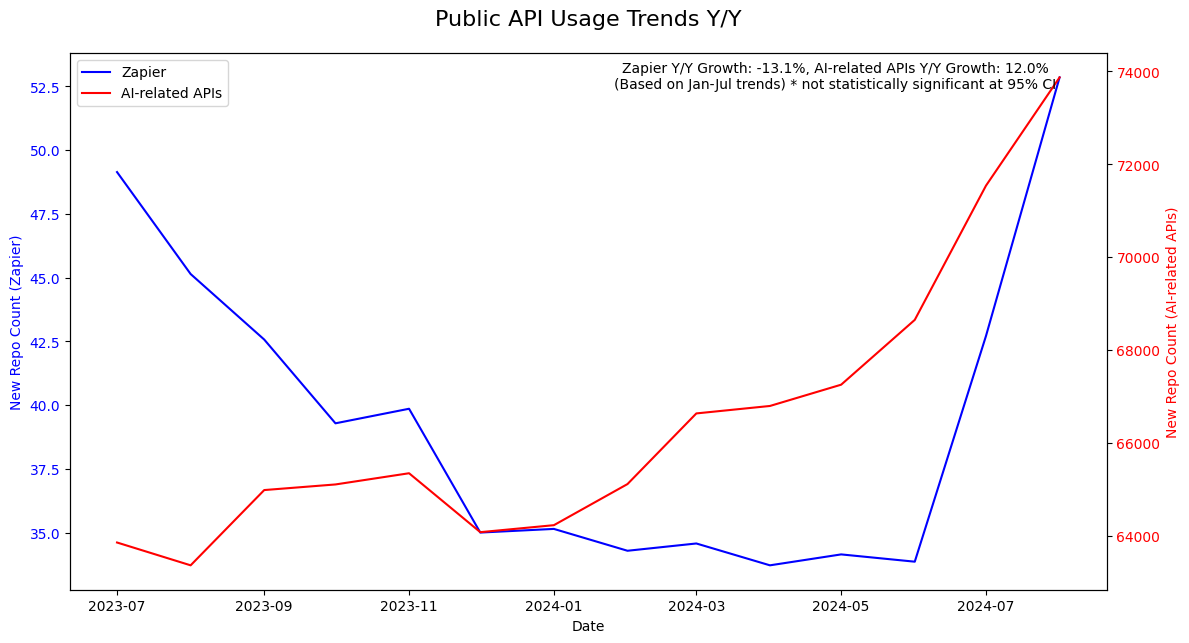

In [24]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot Zapier data on the left y-axis
ax1.plot(zapier_data.index, zapier_data['rolling_avg'], color='blue', label='Zapier')

# Set up the right y-axis for AI-related APIs
ax2 = ax1.twinx()
ax2.plot(ai_apis_data.index, ai_apis_data['rolling_avg'], color='red', label='AI-related APIs')

# Customize the plot
ax1.set_xlabel('Date')
ax1.set_ylabel('New Repo Count (Zapier)', color='blue')
ax2.set_ylabel('New Repo Count (AI-related APIs)', color='red')
ax1.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='red')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Set title and subtitle
plt.title("Public API Usage Trends Y/Y", fontsize=16, pad=20)
plt.figtext(0.7, 0.80, f"Zapier Y/Y Growth: {zapier_yoy:.1f}%, AI-related APIs Y/Y Growth: {ai_apis_yoy:.1f}%\n"
                       f"(Based on Jan-Jul trends) * not statistically significant at 95% CI",
            fontsize=10, ha='center')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust top margin to accommodate subtitle

# Show the plot
plt.show()

Top 5 dimensions correlated with Zapier:
uipath: 0.5948
c3ai: 0.5571
other: 0.5526
oracle_ai: 0.4224
vertex: 0.3602


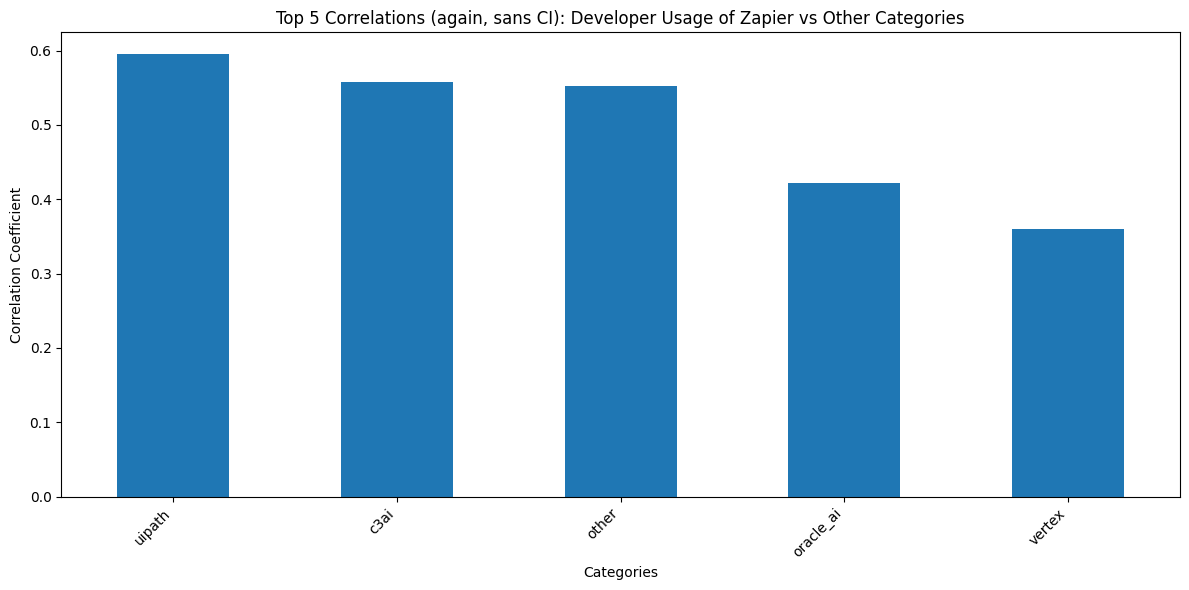

In [30]:
# Create a pivot table with months as index and keyword categories as columns
pivot_data = data.pivot_table(values='new_repo_count', index='month', columns='keyword_category', aggfunc='sum')

# Calculate correlation between Zapier and other categories
correlations = pivot_data.corrwith(pivot_data['zapier']).sort_values(ascending=False)

# Remove Zapier's self-correlation and any NaN values
correlations = correlations.drop('zapier').dropna()

# Get the top 5 correlated categories
top_5_correlations = correlations.head(5)

print("Top 5 dimensions correlated with Zapier:")
for category, correlation in top_5_correlations.items():
    print(f"{category}: {correlation:.4f}")

# Plot the correlation results for top 5
plt.figure(figsize=(12, 6))
top_5_correlations.plot(kind='bar')
plt.title("Top 5 Correlations (again, sans CI): Developer Usage of Zapier vs Other Categories")
plt.xlabel("Categories")
plt.ylabel("Correlation Coefficient")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

